# Strategy

In this notebook, we attempt to train an inverse dynamics model (IDM). In Reinforcement Learning parlance, an IDM learns to predict $a_t$ given $s_t$ and $s_{t+1}$. In our case, we have access to the MetaDrive simulator and the Waymo dataset. We want to predict the action the car should take in MetaDrive so that the successor state in the simulator is as close as possible to the successor state in the Waymo dataset.

In [1]:
import typing
from dataclasses import dataclass
import numpy as np
import numpy.typing as npt

@dataclass
class State:
    heading: float
    velocity: npt.NDArray[np.float64]


Observation: typing.TypeAlias = tuple[State, State]
Action: typing.TypeAlias = tuple[float, float]

In [2]:
import metadrive
from metadrive import MetaDriveEnv
import gymnasium as gym
import typing

import torch
import torch.nn as nn
import torch.nn.functional as F

def deviceof(m: nn.Module) -> torch.device:
    """
    Get the device of the given module
    """
    return next(m.parameters()).device

def normalize_angle(angle: float) -> float:
    """
    Normalize the angle to [-pi, pi)
    """
    return (angle + np.pi) % (2 * np.pi) - np.pi

def get_metadrive_state(env: MetaDriveEnv) -> State:
    return State(heading=env.vehicle.heading_theta, velocity=env.vehicle.velocity[:2])

def next_state(env: MetaDriveEnv, s: State, a: Action) -> State:
    """
    runs the policy and returns the total reward
    """
    # reset
    env.reset()
    env.vehicle.set_position(env.vehicle.position, height=0.49)

    # allow car to settle
    for _ in range(5):
        env.step([0,0])

    # set the initial state
    env.vehicle.set_velocity(s.velocity)
    env.vehicle.set_heading_theta(s.heading)
    
    # run the simulator
    env.step(a)

    # get the new state
    s_prime = get_metadrive_state(env)

    # allow car to settle (if rendering)
    if env.config.use_render:
        for _ in range(10):
            env.step([0,0])

    return s_prime

def gen_scenario() -> tuple[State, Action]:
    """
    Generates a random scenario
    """
    # generate a random state
    velocity = np.random.multivariate_normal([0, 0], np.eye(2) * 100)
    heading = normalize_angle(np.arctan2(velocity[1], velocity[0]) + np.random.normal(0, np.pi/4))

    s = State(heading=heading, velocity=velocity)

    # generate a random action
    steer = np.random.uniform(-1, 1)
    throttle = np.random.uniform(-1, 1)
    a = (steer, throttle)

    return s, a

def state_batch_to_tensor(states: list[State], device: torch.device) -> torch.Tensor:
    """
    Reshape the state from State to a tensor of shape (batch_size, 3)
    """

    return torch.tensor(np.stack([
        [st.velocity[0], st.velocity[1], st.heading] for st in states
    ]), dtype=torch.float32, device=device)

def action_batch_to_tensor(actions: list[Action], device: torch.device) -> torch.Tensor:
    """
    Reshape the action from Action to a tensor of shape (batch_size, 2)
    """
    return torch.tensor(np.stack(actions), dtype=torch.float32, device=device)

def obs_batch_to_tensor(obs: list[Observation], device: torch.device) -> torch.Tensor:
    """
    Reshape the observation from tuple[State, State] to a tensor of shape (batch_size, 3, 2)
    """

    observations = []

    for st0, st1 in obs:
        observations.append(np.array([
            [st0.velocity[0], st1.velocity[0]], 
            [st0.velocity[1], st1.velocity[1]],
            [st0.heading, st1.heading]
        ]))

    return torch.tensor(np.stack(observations), dtype=torch.float32, device=device)

Successfully registered the following environments: ['MetaDrive-validation-v0', 'MetaDrive-10env-v0', 'MetaDrive-100envs-v0', 'MetaDrive-1000envs-v0', 'SafeMetaDrive-validation-v0', 'SafeMetaDrive-10env-v0', 'SafeMetaDrive-100envs-v0', 'SafeMetaDrive-1000envs-v0', 'MARLTollgate-v0', 'MARLBottleneck-v0', 'MARLRoundabout-v0', 'MARLIntersection-v0', 'MARLParkingLot-v0', 'MARLMetaDrive-v0'].


This task may take a few minutes to run the first time.

In [3]:
def generate_data(n_scenarios: int) -> list[tuple[State, Action, State]]:
    env = MetaDriveEnv(config={"on_continuous_line_done": False, "use_render": False})
    dataset: list[tuple[State, Action, State]] = []
    for _ in range(n_scenarios):
        s0, a = gen_scenario()
        s1 = next_state(env, s0, a)
        dataset.append((s0, a, s1))
    env.close()
    return dataset

In [7]:
from concurrent.futures import ProcessPoolExecutor
from metadrive import MetaDriveEnv

MAX_WORKERS = 16
DATASET_SIZE = 80000


mm_train_data: list[tuple[State, Action, State]] = []

with ProcessPoolExecutor(max_workers=MAX_WORKERS) as executor:
    batch_size, leftover_size = divmod(DATASET_SIZE, MAX_WORKERS)
    for batch in executor.map(generate_data, [*[batch_size]*MAX_WORKERS, leftover_size]):
        mm_train_data.extend(batch)

:device:device(warning): /dev/input/event6 is not readable, some features will be unavailable.
:device(warning): /dev/input/event6 is not readable, some features will be unavailable.
:device(warning): /dev/input/event7 is not readable, some features will be unavailable.
:device(warning): /dev/input/event6 is not readable, some features will be unavailable.
:device(warning): /dev/input/event7 is not readable, some features will be unavailable.
:device(warning): /dev/input/event7 is not readable, some features will be unavailable.
:device(warning): /dev/input/event23 is not readable, some features will be unavailable.
:device(warning): /dev/input/event6 is not readable, some features will be unavailable.
(warning): /dev/input/event6 is not readable, some features will be unavailable.
:device(warning): /dev/input/event23 is not readable, some features will be unavailable.
:device(warning): /dev/input/event7 is not readable, some features will be unavailable.
:device(warning): /dev/input/e

In [7]:
mm_validation_data = generate_data(1000)

:device(warning): /dev/input/event6 is not readable, some features will be unavailable.
:device(warning): /dev/input/event7 is not readable, some features will be unavailable.
:device(warning): /dev/input/event23 is not readable, some features will be unavailable.


In [8]:
import pickle
import os

# pickle the data
if not os.path.exists('data/mm_train_data.pkl'):
    with open('data/mm_train_data.pkl', 'wb') as f:
        pickle.dump(mm_train_data, f)

if not os.path.exists('data/mm_validation_data.pkl'):
    with open('data/mm_validation_data.pkl', 'wb') as f:
        pickle.dump(mm_validation_data, f)



In [4]:
import pickle
import os

if 'mm_train_data' not in locals():
    # load data (if exists)   
    with open('data/mm_train_data.pkl', 'rb') as f:
        mm_train_data = pickle.load(f)

if 'mm_validation_data' not in locals():
    with open('data/mm_validation_data.pkl', 'rb') as f:
        mm_validation_data = pickle.load(f)

In [5]:
print("training data:", len(mm_train_data))
print("validation data:", len(mm_validation_data))

training data: 40000
validation data: 1000


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# create a model that attempts to predict the next state given the current state and the action: (throttle and steering)
# each state contains: velocity_x, velocity_y, and heading
class MetadriveModel(nn.Module):
    def __init__(self):
        super().__init__()
        # input shape: (batch_size, 3) + (batch_size, 2) = (batch_size, 5)
        # output shape: (batch_size, 3)
        self.fc1 = nn.Linear(5, 512) # Bx5 -> Bx512
        self.fc2 = nn.Linear(512, 512) # Bx512 -> Bx256
        self.fc3 = nn.Linear(512, 3) # Bx256 -> Bx3
    
    def forward(self, states: torch.Tensor, actions: torch.Tensor):
        x = torch.cat([states, actions], dim=1) # Bx5
        x = F.relu(self.fc1(x)) # Bx512
        x = F.relu(self.fc2(x)) # Bx512
        x = self.fc3(x) # Bx3
        return x

def metadrive_model_train_batch(
    mm: MetadriveModel,
    mm_optimizer: torch.optim.Optimizer,
    s0_batch: list[State],
    a_batch: list[Action],
    s1_batch: list[State],
) -> float: 
    device = deviceof(mm)

    s0_tensor = state_batch_to_tensor(s0_batch, device) 
    a_tensor = action_batch_to_tensor(a_batch, device)
    s1_tensor = state_batch_to_tensor(s1_batch, device)

    mm_optimizer.zero_grad()
    s1_pred_tensor = mm(s0_tensor, a_tensor)
    loss = F.mse_loss(s1_pred_tensor, s1_tensor)
    loss.backward()
    mm_optimizer.step()
    return float(loss.item())



In [7]:
def set_lr(optimizer: torch.optim.Optimizer, lr: float) -> None:
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
import itertools
# make sure we don't run out of data
mm_train_iter = itertools.cycle(mm_train_data)

mm = MetadriveModel().to(device)

mm_optimizer = torch.optim.Adam(mm.parameters())

mm_step = 0
mm_losses = []

In [36]:
set_lr(mm_optimizer, 1e-4)
METADRIVE_MODEL_TRAIN_EPOCHS = 15000
METADRIVE_MODEL_TRAIN_BATCH_SIZE = 4096

while mm_step < METADRIVE_MODEL_TRAIN_EPOCHS:
    # take up to n from the data buffer
    data_batch = [next(mm_train_iter) for _ in range(METADRIVE_MODEL_TRAIN_BATCH_SIZE)]
    # unpack the batch
    s0_batch = [s0 for s0, _, _ in data_batch]
    a_batch = [a for _, a, _ in data_batch]
    s1_batch = [s1 for _, _, s1 in data_batch]
    loss = metadrive_model_train_batch(mm, mm_optimizer, s0_batch, a_batch, s1_batch)
    mm_losses.append(loss)
    mm_step += 1
    if mm_step % 100 == 0:
        print(f"Step: {mm_step}, Loss: {loss:.4f}")

Step: 100, Loss: 0.217
Step: 200, Loss: 0.120
Step: 300, Loss: 0.106
Step: 400, Loss: 0.101
Step: 500, Loss: 0.095
Step: 600, Loss: 0.090
Step: 700, Loss: 0.086
Step: 800, Loss: 0.080
Step: 900, Loss: 0.077
Step: 1000, Loss: 0.073
Step: 1100, Loss: 0.073
Step: 1200, Loss: 0.069
Step: 1300, Loss: 0.066
Step: 1400, Loss: 0.063
Step: 1500, Loss: 0.059
Step: 1600, Loss: 0.056
Step: 1700, Loss: 0.057
Step: 1800, Loss: 0.054
Step: 1900, Loss: 0.052
Step: 2000, Loss: 0.051
Step: 2100, Loss: 0.047
Step: 2200, Loss: 0.045
Step: 2300, Loss: 0.045
Step: 2400, Loss: 0.044
Step: 2500, Loss: 0.042
Step: 2600, Loss: 0.041
Step: 2700, Loss: 0.038
Step: 2800, Loss: 0.036
Step: 2900, Loss: 0.038
Step: 3000, Loss: 0.036
Step: 3100, Loss: 0.035
Step: 3200, Loss: 0.034
Step: 3300, Loss: 0.031
Step: 3400, Loss: 0.030
Step: 3500, Loss: 0.029
Step: 3600, Loss: 0.031
Step: 3700, Loss: 0.030
Step: 3800, Loss: 0.029
Step: 3900, Loss: 0.029
Step: 4000, Loss: 0.026
Step: 4100, Loss: 0.025
Step: 4200, Loss: 0.027
S

In [9]:
# load mm
if 'mm' not in locals():
    mm = MetadriveModel().to(device)
    mm.load_state_dict(torch.load('data/mm.pth'))

<All keys matched successfully>

In [37]:
# save mm
if not os.path.exists('data/mm.pth'):
    torch.save(mm.state_dict(), 'data/mm.pth')

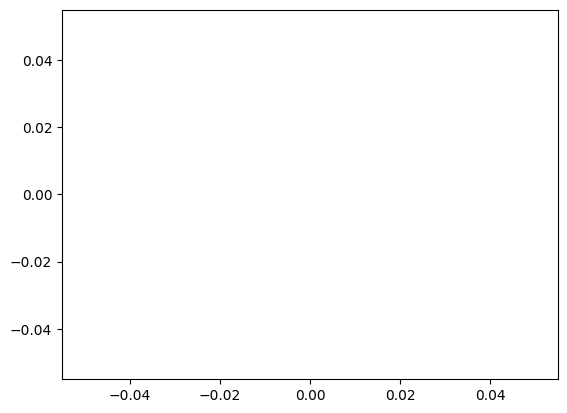

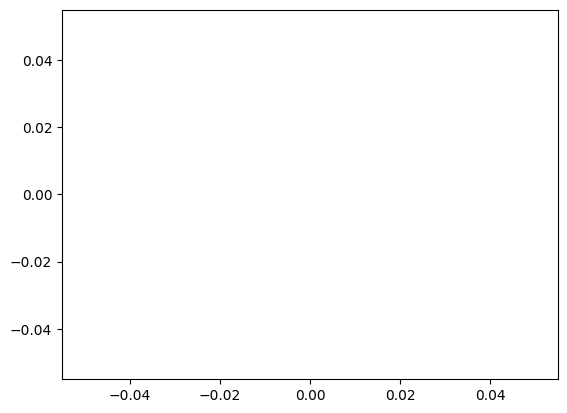

In [10]:
import matplotlib.pyplot as plt

# Plot the losses over training
plt.plot(list(range(len(mm_losses))), mm_losses, label='MM')
plt.show()

latter_training = mm_losses[500:]
plt.plot(list(range(len(latter_training))), latter_training, label='MM')
plt.show()

In [39]:
s0_batch = [s0 for s0, _, _ in mm_validation_data]
s1_batch = [s1 for _, _, s1 in mm_validation_data]
a_batch = [a for _, a, _ in mm_validation_data]

s0_tensor = state_batch_to_tensor(s0_batch, device)
s1_tensor = state_batch_to_tensor(s1_batch, device)
a_tensor = action_batch_to_tensor(a_batch, device)

s1_pred = mm(s0_tensor, a_tensor)

loss = (s1_pred - s1_tensor)**2
loss_x = loss[:, 0]
loss_y = loss[:, 1]
loss_theta = loss[:, 2]

print("validation loss", loss.mean().item())

validation loss 0.02123415097594261


In [40]:
s0_batch = [s0 for s0, _, _ in mm_train_data]
s1_batch = [s1 for _, _, s1 in mm_train_data]
a_batch = [a for _, a, _ in mm_train_data]

s0_tensor = state_batch_to_tensor(s0_batch, device)
s1_tensor = state_batch_to_tensor(s1_batch, device)
a_tensor = action_batch_to_tensor(a_batch, device)

s1_pred = mm(s0_tensor, a_tensor)

loss = (s1_pred - s1_tensor)**2
loss_x = loss[:, 0]
loss_y = loss[:, 1]
loss_theta = loss[:, 2]

print("training loss", loss.mean().item())



training loss 0.006551372818648815


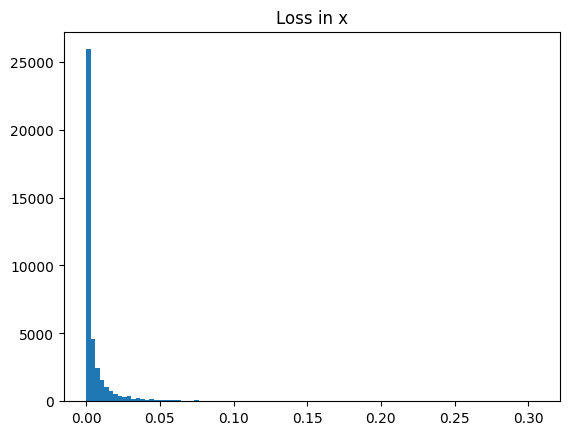

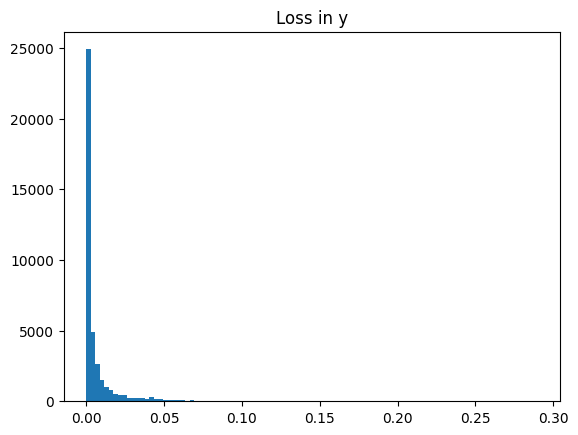

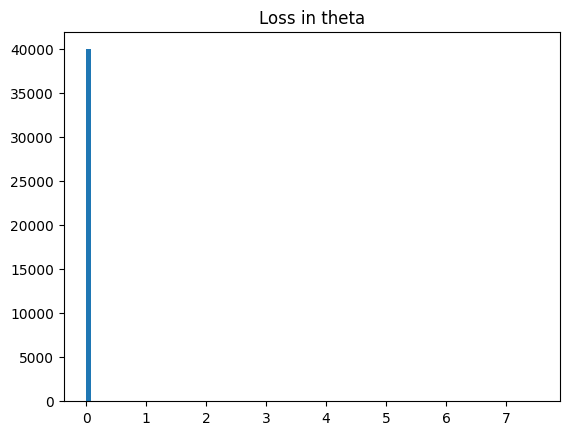

In [41]:
plt.hist(loss_x.cpu().detach().numpy(), bins=100)
plt.title('Loss in x')
plt.show()
plt.hist(loss_y.cpu().detach().numpy(), bins=100)
plt.title('Loss in y')
plt.show()
plt.hist(loss_theta.cpu().detach().numpy(), bins=100)
plt.title('Loss in theta')
plt.show()


Now that we have trained a neural network model of Metadrive through which we can backprop, training the IDM is easy.

In [11]:
from protos import scenario_pb2
# tensorflow don't allocate all gpu memory right away
import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
import tensorflow as tf
import tqdm

def getFiles(path: str) -> list[str]:
    path = os.path.expanduser(path)
    files = [os.path.join(path, f) for f in os.listdir(path)]
    return [f for f in files if os.path.isfile(f)]


files = getFiles('~/data/waymo/')

def parse_scenario(scenario: scenario_pb2.Scenario) -> list[State]:
    states = []
    for s in scenario.tracks[scenario.sdc_track_index].states:
        if s.valid:
            states.append(State(s.heading, np.array([s.velocity_x, s.velocity_y], dtype=np.float32)))
    return states


h: list[list[State]] = []

for file_path in tqdm.tqdm(files):
    for data in tf.data.TFRecordDataset(file_path, compression_type="").as_numpy_iterator():
        scenario = scenario_pb2.Scenario()
        scenario.ParseFromString(data)
        h.append(parse_scenario(scenario))


2023-08-11 22:47:16.225994: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-11 22:47:17.379143: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
  0%|          | 0/100 [00:00<?, ?it/s]2023-08-11 22:47:18.204849: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-11 22:47:18.224628: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at l

KeyboardInterrupt: 

In [12]:
idm_train_data: list[Observation] = []
for states in h:
    for i in range(len(states)-1):
        idm_train_data.append((states[i], states[i+1]))

print("train data:", len(idm_train_data))

train data: 145374


In [85]:
import pickle
import os

# pickle the data
if not os.path.exists('data/idm_train_data.pkl'):
    with open('data/idm_train_data.pkl', 'wb') as f:
        pickle.dump(idm_train_data, f)

In [ ]:
import pickle
import os

if 'idm_train_data' not in locals():
    # load data (if exists)   
    with open('data/idm_train_data.pkl', 'rb') as f:
        idm_train_data = pickle.load(f)

In [37]:
# creates a model that attempts to predict the action given the current state and the next state
class InverseDynamicsModel(nn.Module):
    def __init__(self):
        super().__init__()
        # input shape: (batch_size, 3, 2)
        # output shape: (batch_size, 2)

        self.conv1 = nn.Conv1d(3, 768, 2) # Bx3x2 -> Bx768x1
        self.fc1 = nn.Linear(768, 768) # Bx768 -> Bx768
        self.fc2 = nn.Linear(768, 2) # Bx768 -> Bx2
    
    def forward(self, x: torch.Tensor):
        x = F.relu(self.conv1(x)) # Bx3x2 -> Bx768x1
        x = torch.flatten(x, 1) # Bx768x1 -> Bx768
        x = F.relu(self.fc1(x)) # Bx768 -> Bx768
        x = self.fc2(x) # Bx768 -> Bx2
        return x

def idm_train_batch(
        mm: MetadriveModel,
        idm: InverseDynamicsModel,
        idm_optimizer: torch.optim.Optimizer,
        obs_batch: list[Observation],
) -> float:
    device = deviceof(mm)

    assert deviceof(idm) == device

    obs_tensor = obs_batch_to_tensor(obs_batch, device)
    s0_tensor = state_batch_to_tensor([s0 for s0, _ in obs_batch], device)
    s1_tensor = state_batch_to_tensor([s1 for _, s1 in obs_batch], device)

    idm_optimizer.zero_grad()

    pred_action = idm(obs_tensor)
    pred_s1 = mm(s0_tensor, pred_action)

    loss = F.huber_loss(pred_s1, s1_tensor, delta=1.0)
    loss.backward()

    idm_optimizer.step()

    return float(loss.item())

In [50]:
idm_train_iter = itertools.cycle(idm_train_data)

idm = InverseDynamicsModel().to(device)

idm_optimizer = torch.optim.Adam(idm.parameters())

idm_step = 0
idm_losses = []

In [57]:
set_lr(idm_optimizer, 1e-5)
INVERSE_DYNAMICS_MODEL_TRAIN_EPOCHS = 10000
INVERSE_DYNAMICS_MODEL_TRAIN_BATCH_SIZE = 2048

while idm_step < INVERSE_DYNAMICS_MODEL_TRAIN_EPOCHS:
    obs_batch = [next(idm_train_iter) for _ in range(INVERSE_DYNAMICS_MODEL_TRAIN_BATCH_SIZE)]
    loss = idm_train_batch(
        mm,
        idm,
        idm_optimizer,
        obs_batch,
    )
    idm_losses.append(loss)
    idm_step += 1
    if idm_step % 100 == 0:
        print(f"Step: {idm_step}, Loss: {loss:.3f}")

Step: 6600, Loss: 0.010
Step: 6700, Loss: 0.010
Step: 6800, Loss: 0.007
Step: 6900, Loss: 0.010
Step: 7000, Loss: 0.002
Step: 7100, Loss: 0.002
Step: 7200, Loss: 0.012
Step: 7300, Loss: 0.010
Step: 7400, Loss: 0.007
Step: 7500, Loss: 0.016
Step: 7600, Loss: 0.007
Step: 7700, Loss: 0.008
Step: 7800, Loss: 0.012
Step: 7900, Loss: 0.018
Step: 8000, Loss: 0.010
Step: 8100, Loss: 0.022
Step: 8200, Loss: 0.019
Step: 8300, Loss: 0.006
Step: 8400, Loss: 0.016
Step: 8500, Loss: 0.009
Step: 8600, Loss: 0.008
Step: 8700, Loss: 0.005
Step: 8800, Loss: 0.008
Step: 8900, Loss: 0.005
Step: 9000, Loss: 0.010
Step: 9100, Loss: 0.017
Step: 9200, Loss: 0.007
Step: 9300, Loss: 0.002
Step: 9400, Loss: 0.012
Step: 9500, Loss: 0.012
Step: 9600, Loss: 0.006
Step: 9700, Loss: 0.007
Step: 9800, Loss: 0.008
Step: 9900, Loss: 0.005
Step: 10000, Loss: 0.009


In [31]:
# load mm
if 'idm' not in locals():
    idm = InverseDynamicsModel().to(device)
    idm.load_state_dict(torch.load('data/idm.pth'))    

In [84]:
# save mm
if not os.path.exists('data/idm.pth'):
    torch.save(mm.state_dict(), 'data/idm.pth')

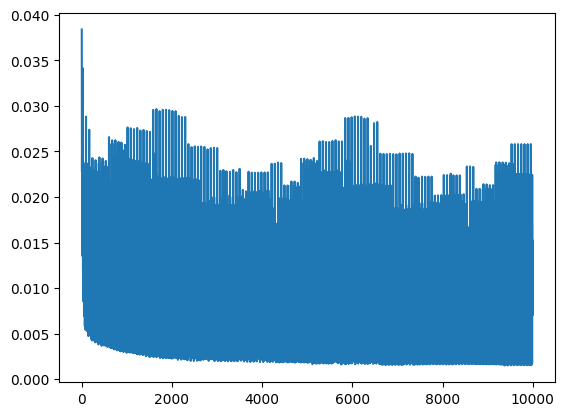

In [58]:
import matplotlib.pyplot as plt

# Plot the losses over training
plt.plot(list(range(len(idm_losses))), idm_losses, label='IDM')
plt.show()

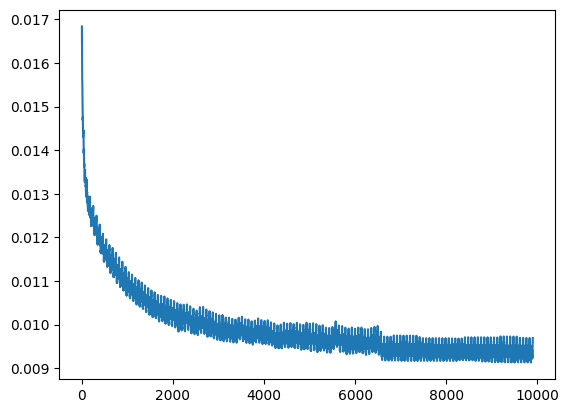

In [59]:
# compute running average of the last 100 episodes
# plot the average reward per episode
idm_losses_averaged = np.convolve(idm_losses, np.ones((100,))/100, mode='valid')
plt.plot(idm_losses_averaged)

Let' compare our trained IDM against the null idm (predicts 0 for all values):

In [79]:
obs_batch = idm_train_data

obs_tensor = obs_batch_to_tensor(obs_batch, device)
s0_tensor = state_batch_to_tensor([s0 for s0, _ in obs_batch], device)
s1_tensor = state_batch_to_tensor([s1 for _, s1 in obs_batch], device)
with torch.no_grad():
    action_pred = idm(obs_tensor)
    s1_pred = mm(s0_tensor, action_pred)

loss = (s1_pred - s1_tensor)**2
loss_x = loss[:, 0].cpu().detach().numpy()
loss_y = loss[:, 1].cpu().detach().numpy()
loss_theta = loss[:, 2].cpu().detach().numpy()

print("training loss", loss.mean().item())

training loss 0.01918603852391243


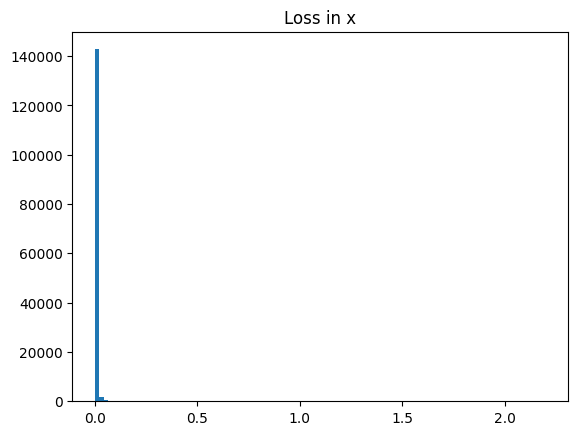

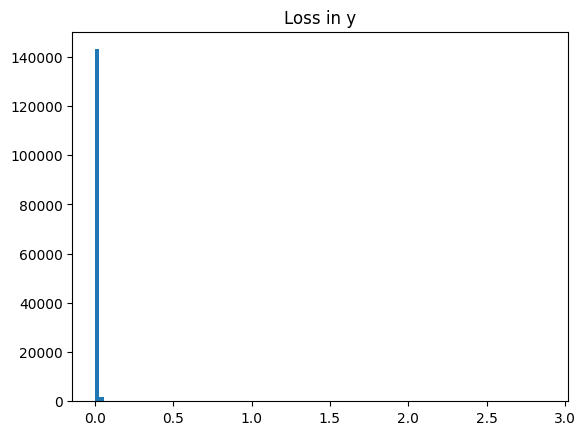

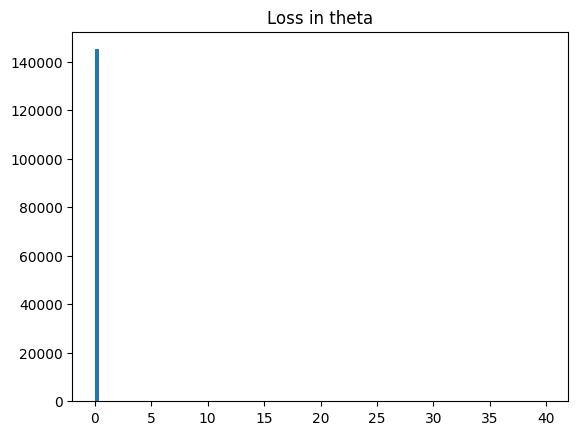

In [80]:
plt.hist(loss_x, bins=100)
plt.title('Loss in x')
plt.show()
plt.hist(loss_y, bins=100)
plt.title('Loss in y')
plt.show()
plt.hist(loss_theta, bins=100)
plt.title('Loss in theta')
plt.show()


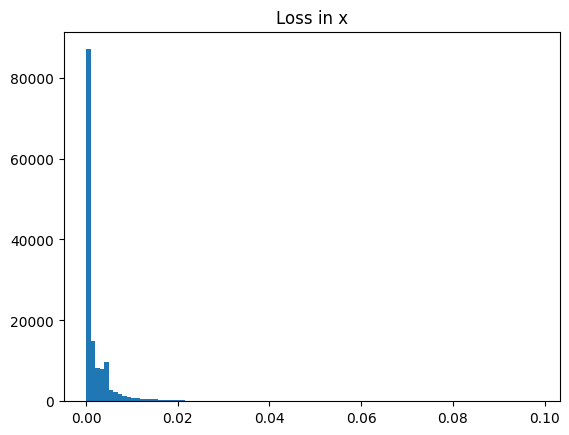

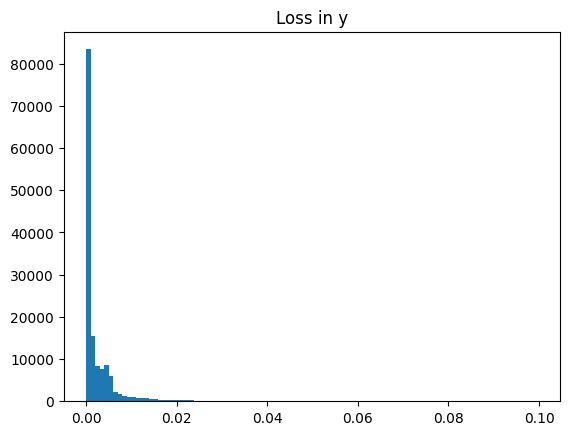

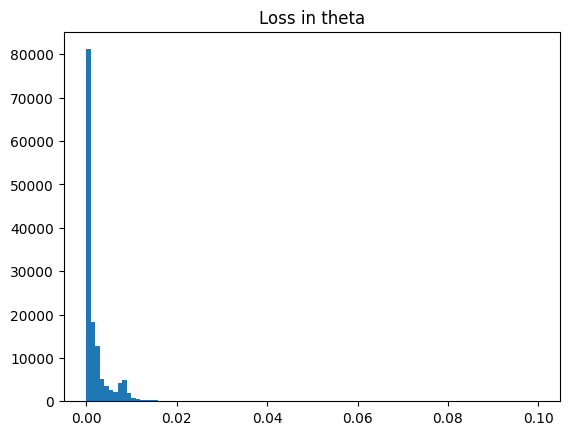

In [82]:
loss_x_no_outliers = np.array([x for x in loss_x if x < 0.1 ]) 
loss_y_no_outliers = np.array([x for x in loss_y if x < 0.1 ])
loss_theta_no_outliers = np.array([x for x in loss_theta if x < 0.1 ])

plt.hist(loss_x_no_outliers, bins=100)
plt.title('Loss in x')
plt.show()
plt.hist(loss_y_no_outliers, bins=100)
plt.title('Loss in y')
plt.show()
plt.hist(loss_theta_no_outliers, bins=100)
plt.title('Loss in theta')
plt.show()


Let's try visualizing our IDM by having it follow a track from start to finish.

In [30]:
class IDMPolicy:
    def __init__(self, net: InverseDynamicsModel):
        self.net = net

    def __call__(self, obs:Observation) -> Action:
        # sample an action from the policy network
        obs_tensor = obs_batch_to_tensor([obs], deviceof(self.net))
        # sample an action from the policy network
        with torch.no_grad():
            steering, throttle = self.net(obs_tensor)[0]
        return steering.item(), throttle.item()


In [63]:
env = gym.make("MetaDrive-validation-v0", config={"on_continuous_line_done": False, "use_render": True})

In [76]:
scenario = h[10]
with torch.no_grad():
    # reset
    env.reset()

    # allow car to settle
    for _ in range(10):
        env.step([0,0])

    st = scenario[0]

    # set the initial state
    env.vehicle.set_velocity(st.velocity)
    env.vehicle.set_heading_theta(st.heading)


    for i in range(len(scenario)-1):
        st0 = scenario[i]
        st1 = scenario[i+1]
        st0_pred = get_metadrive_state(env)
        action = IDMPolicy(idm)((st0_pred, st1))
        env.step(action)
        st1_pred = get_metadrive_state(env)
        print(action)
        print(st1_pred.velocity, st1_pred.heading, st1.velocity, st1.heading)
        

(0.25402453541755676, 1.8723362684249878)
[-3.41859603 -9.27359772] -1.963580097016285 [-3.8263557 -8.978652 ] -1.9706326723098755
(-0.3556893467903137, 1.9321879148483276)
[-3.78267503 -9.18082142] -1.9467691589512688 [-3.8337712 -8.954906 ] -1.9715917110443115
(0.05622897669672966, 1.8673193454742432)
[-3.59968805 -9.53277397] -1.947036274008604 [-3.8455663 -8.938296 ] -1.9727298021316528
(-0.3080879747867584, 2.007103204727173)
[-4.01502657 -9.44846821] -1.9438327575333476 [-4.036845 -9.381228] -1.9738435745239258
(0.16399919986724854, 1.8888007402420044)
[-3.67772746 -9.73877811] -1.9529887053610402 [-4.046416 -9.365672] -1.975146770477295
(-0.3714004158973694, 1.6796022653579712)
[-4.1033721  -9.61366653] -1.9485196547357777 [-3.8521392 -8.883777 ] -1.976261019706726
(0.16566553711891174, 1.5912766456604004)
[-3.74681354 -9.91312122] -1.9562569366507851 [-3.8432453 -8.863219 ] -1.9772320985794067
(-0.3867339789867401, 1.5806682109832764)
[-4.16188002 -9.78412819] -1.94974524146943

INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.5107241868972778, 1.5243521928787231)
[-4.26015997 -9.85219765] -1.9447153291185995 [-3.90412  -8.963332] -1.9794386625289917


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.18076196312904358, 1.5511473417282104)
[ -4.14099884 -10.03797626] -1.9579453807818954 [-3.9349024 -9.0136795] -1.9797446727752686


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0317695289850235, 1.54595947265625)
[ -4.32067251 -10.18217754] -1.958308635954582 [-3.9465911 -9.055266 ] -1.9798685312271118


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0739133283495903, 1.4514378309249878)
[ -4.19927406 -10.37352848] -1.9608239916041619 [-3.9712644 -9.082525 ] -1.979722023010254


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.15432119369506836, 1.4336791038513184)
[ -4.6122508  -10.27969933] -1.9626333432487622 [-3.9829106 -9.118758 ] -1.9791587591171265


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.34939590096473694, 1.3470590114593506)
[ -3.6774292  -10.47915459] -1.9704649010663582 [-3.9836547 -9.173546 ] -1.9787720441818237


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.7286590337753296, 1.5283973217010498)
[-4.18574619 -9.98330593] -1.9542092320886235 [-4.011596 -9.220034] -1.9785798788070679


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.05410108342766762, 1.6639347076416016)
[ -4.04180384 -10.31883335] -1.9563429567539945 [-4.031294 -9.252959] -1.978377342224121


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.2689986824989319, 1.5900342464447021)
[ -4.34741592 -10.30494308] -1.9510579135707324 [-4.038215 -9.294509] -1.9785630702972412


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.05584418773651123, 1.5460821390151978)
[ -4.13927984 -10.65632439] -1.9550609110052308 [-4.0686717 -9.34169  ] -1.9784832000732422


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.34272968769073486, 1.479637861251831)
[ -4.55132008 -10.54986668] -1.9524454204986643 [-4.092535 -9.398284] -1.9781137704849243


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.1440524309873581, 1.4474108219146729)
[ -4.2049222  -10.85869598] -1.9615859219920342 [-4.105677 -9.450809] -1.9778414964675903


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.3562312424182892, 1.4228055477142334)
[ -4.63704634 -10.72748566] -1.9558081940071066 [-4.124155 -9.489477] -1.9775582551956177


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.14630848169326782, 1.3872493505477905)
[ -4.28554964 -11.03638935] -1.9631145764577393 [-4.1304245 -9.520983 ] -1.977067232131958


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.3339184522628784, 1.3471366167068481)
[ -4.70009279 -10.92622948] -1.956405008407394 [-4.133854 -9.543431] -1.9766690731048584


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.12823045253753662, 1.3055531978607178)
[ -4.35925102 -11.2467165 ] -1.962245853310156 [-4.1391954 -9.570838 ] -1.9763585329055786


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.3415914475917816, 1.2508198022842407)
[ -4.76699448 -11.1358099 ] -1.955010843576737 [-4.149292 -9.591985] -1.9762396812438965


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.09048238396644592, 1.2304675579071045)
[ -4.44663239 -11.49376106] -1.960740102029824 [-4.1554065 -9.604778 ] -1.9760092496871948


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.35272714495658875, 1.1379666328430176)
[ -4.84910917 -11.38084412] -1.9535905797673987 [-4.1546526 -9.621367 ] -1.976073980331421


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.06124443560838699, 1.1373558044433594)
[ -4.59983683 -11.74544811] -1.9595038626518093 [-4.1671047 -9.64578  ] -1.976248025894165


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.31718096137046814, 1.0325186252593994)
[ -5.01562643 -11.64297485] -1.9555376168403544 [-4.183504 -9.66964 ] -1.97653067111969


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.08922570198774338, 1.0291718244552612)
[ -4.70751429 -11.98967361] -1.9637582624932115 [-4.2048397 -9.699744 ] -1.9770113229751587


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.3306347727775574, 0.9523255825042725)
[ -5.12153387 -11.86963081] -1.9580372598395037 [-4.2279477 -9.740065 ] -1.9775822162628174


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.07429613173007965, 0.9642327427864075)
[ -4.82679749 -12.22553158] -1.9647915689961621 [-4.253814 -9.77683 ] -1.9783499240875244


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.33764293789863586, 0.8688255548477173)
[ -5.2294445  -12.09206772] -1.9590154389078895 [-4.27618  -9.803373] -1.9792183637619019


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.04279293864965439, 0.8872098922729492)
[ -5.03212595 -12.41976738] -1.9662640307628667 [-4.310493 -9.823365] -1.9800052642822266


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.25810179114341736, 0.7753547430038452)
[ -5.46209526 -12.29146385] -1.9656083605024897 [-4.323162 -9.849826] -1.9810434579849243


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.16149523854255676, 0.772180438041687)
[ -5.12026644 -12.53477859] -1.9762444932640477 [-4.3367324 -9.863684 ] -1.9826723337173462


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.25470152497291565, 0.7138051986694336)
[ -5.55538082 -12.38673592] -1.9717168530948044 [-4.3614464 -9.849596 ] -1.9838989973068237


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.178229421377182, 0.6897057890892029)
[ -5.17845154 -12.6201725 ] -1.979657866833202 [-4.3578672 -9.833144 ] -1.9851499795913696


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.25277599692344666, 0.642082929611206)
[ -5.59697008 -12.46561337] -1.973223137007353 [-4.3709054 -9.817563 ] -1.9865949153900146


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.15368609130382538, 0.626153826713562)
[ -5.21594906 -12.7029829 ] -1.9800051430393486 [-4.381085 -9.805317] -1.987837791442871


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.2698450982570648, 0.5786912441253662)
[ -5.62067127 -12.53518105] -1.9730811905212517 [-4.3836875 -9.793788 ] -1.988980770111084


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.1293455958366394, 0.5633411407470703)
[ -5.23568296 -12.7764616 ] -1.9795295024686608 [-4.387796 -9.770896] -1.9900315999984741


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.30362334847450256, 0.5118833780288696)
[ -5.62903976 -12.58674049] -1.9722819758781185 [-4.3928943 -9.75017  ] -1.9909881353378296


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0952569767832756, 0.5148665904998779)
[ -5.24571896 -12.84311008] -1.9785193654671938 [-4.397542 -9.736333] -1.9922282695770264


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.33741575479507446, 0.4643852114677429)
[ -5.62677145 -12.6370182 ] -1.9709866143239045 [-4.4025693 -9.727191 ] -1.9931846857070923


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.053475216031074524, 0.4782695770263672)
[ -5.33523321 -12.8825531 ] -1.9770857858524042 [-4.4109464 -9.714221 ] -1.9940462112426758


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.28899946808815, 0.4201068580150604)
[ -5.73465061 -12.6808157 ] -1.9737911892678675 [-4.409725 -9.709429] -1.9947118759155273


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.12778215110301971, 0.435878187417984)
[ -5.35603189 -12.89252663] -1.9829830897702756 [-4.414761 -9.713248] -1.9954811334609985


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.28908151388168335, 0.4223161041736603)
[ -5.76079035 -12.68432426] -1.9772820608247432 [-4.429994 -9.714862] -1.9961519241333008


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.14100030064582825, 0.43896299600601196)
[ -5.36341143 -12.89810276] -1.9845474305945885 [-4.427908 -9.722151] -1.996717929840088


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.2857697606086731, 0.4225665330886841)
[ -5.75948811 -12.69513416] -1.9775459800887702 [-4.4337206 -9.719471 ] -1.9971978664398193


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.12196485698223114, 0.4236534535884857)
[ -5.36223602 -12.91738129] -1.9840254510209325 [-4.435355 -9.703488] -1.997387170791626


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.2964246869087219, 0.3896281123161316)
[ -5.74971581 -12.70847988] -1.976710280138703 [-4.424277 -9.686153] -1.9977781772613525


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.10178718715906143, 0.3862690031528473)
[ -5.35129547 -12.93630028] -1.9829663118554084 [-4.424091 -9.657473] -1.9980777502059937


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.32183563709259033, 0.3281606435775757)
[ -5.72969484 -12.7102356 ] -1.9754343596604453 [-4.4071803 -9.61293  ] -1.9982733726501465


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.09038298577070236, 0.3111270070075989)
[ -5.32640266 -12.92988396] -1.981523411176803 [-4.377862 -9.554643] -1.998475193977356


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.3371575176715851, 0.23096343874931335)
[ -5.69727802 -12.68385887] -1.9739397936566938 [-4.3587117 -9.481028 ] -1.9989800453186035


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.05836119502782822, 0.23333081603050232)
[ -5.35991573 -12.87722969] -1.9801263168689474 [-4.3409076 -9.418573 ] -1.9997538328170776


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.2904473543167114, 0.15234902501106262)
[ -5.74688864 -12.62822723] -1.9760554088266522 [-4.315997 -9.35969 ] -2.0007078647613525


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.1237315908074379, 0.15373319387435913)
[ -5.33534527 -12.79495049] -1.9849804605878347 [-4.288582 -9.286154] -2.001086711883545


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.2722381353378296, 0.08226602524518967)
[ -5.72599173 -12.5352211 ] -1.9789593196792747 [-4.2573233 -9.215388 ] -2.001176595687866


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.1520351767539978, 0.10527361184358597)
[ -5.29164648 -12.68904591] -1.9862478589506036 [-4.2290697 -9.160127 ] -2.001364231109619


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.2602100372314453, 0.06140429526567459)
[ -5.67745256 -12.43201923] -1.9791513335938697 [-4.208724  -9.1109705] -2.0016510486602783


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.14805133640766144, 0.09855816513299942)
[ -5.24037266 -12.5874815 ] -1.9858694237597039 [-4.1961665 -9.072126 ] -2.001755475997925


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.26940229535102844, 0.07171494513750076)
[ -5.62213707 -12.33111572] -1.9785537202452552 [-4.1858354 -9.0464525] -2.001856565475464


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.14652344584465027, 0.11734164506196976)
[ -5.18580961 -12.49067783] -1.9851056291590687 [-4.1686144 -9.0190115] -2.001850128173828


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.26231926679611206, 0.09226470440626144)
[ -5.56965971 -12.24053669] -1.9777052371219561 [-4.150242 -9.000419] -2.001549243927002


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.15011438727378845, 0.14226004481315613)
[ -5.13489103 -12.40282917] -1.9842227912577073 [-4.1417737 -8.983374 ] -2.0012712478637695


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.27848905324935913, 0.12815037369728088)
[ -5.51782179 -12.15389061] -1.9768181381628516 [-4.142393 -8.971043] -2.0010902881622314


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.13585929572582245, 0.1948326826095581)
[ -5.08982086 -12.3310461 ] -1.9832680480069138 [-4.1453075 -8.9823065] -2.0012829303741455


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.30012670159339905, 0.21017754077911377)
[ -5.47187042 -12.08983326] -1.9757946853559343 [-4.1624694 -9.000966 ] -2.0018551349639893


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.09983447194099426, 0.2693699598312378)
[ -5.05892467 -12.29801464] -1.9820866697473551 [-4.1825047 -9.021571 ] -2.002131938934326


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.3386845290660858, 0.2928479015827179)
[ -5.43441534 -12.06069374] -1.9744796164096527 [-4.2057295 -9.053387 ] -2.002612829208374


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.06275301426649094, 0.354727178812027)
[ -5.10353041 -12.28384304] -1.9805156710203171 [-4.229086  -9.0973835] -2.003079652786255


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.30252188444137573, 0.3731497824192047)
[ -5.49570084 -12.06959248] -1.9760330382734956 [-4.2497954 -9.149985 ] -2.0034596920013428


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.10372728854417801, 0.4212242662906647)
[ -5.11559963 -12.29762173] -1.9844984284305305 [-4.2759223 -9.197873 ] -2.0034499168395996


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.2970220446586609, 0.45002108812332153)
[ -5.51546097 -12.09394073] -1.9783819463549452 [-4.292007 -9.253731] -2.0032565593719482


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.11201983690261841, 0.49522310495376587)
[ -5.13033867 -12.33656025] -1.985310159930787 [-4.3184824 -9.316331 ] -2.0031657218933105


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.30850157141685486, 0.5234643220901489)
[ -5.52431107 -12.14435482] -1.978168094519413 [-4.344252 -9.374197] -2.0030622482299805


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.08760733902454376, 0.5595390200614929)
[ -5.15860987 -12.41640186] -1.9843924346191457 [-4.3722944 -9.428206 ] -2.0029711723327637


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.3258766233921051, 0.552230954170227)
[ -5.54481506 -12.22692013] -1.9772250691774147 [-4.390965 -9.474797] -2.002575635910034


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.08405886590480804, 0.5758686065673828)
[ -5.18461514 -12.50390434] -1.9833860260432044 [-4.393373 -9.513635] -2.0023860931396484


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.3374800980091095, 0.5423374176025391)
[ -5.56849527 -12.30908585] -1.9763116049235183 [-4.4123225 -9.532401 ] -2.0022976398468018


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.05792537331581116, 0.5619677305221558)
[ -5.27584362 -12.57806396] -1.9826456672601624 [-4.422707 -9.551476] -2.0024893283843994


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.2916845381259918, 0.5187695622444153)
[ -5.67684126 -12.39055824] -1.978803524755505 [-4.4325023 -9.574848 ] -2.0027832984924316


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.11105484515428543, 0.522788941860199)
[ -5.30990171 -12.63121796] -1.987551209988089 [-4.446277 -9.585983] -2.002880334854126


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.2893717586994171, 0.5017372965812683)
[ -5.71428347 -12.43636322] -1.9816413892130935 [-4.4492106 -9.592794 ] -2.002880811691284


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.12727952003479004, 0.49714040756225586)
[ -5.32670736 -12.66991329] -1.9886921081990785 [-4.4491825 -9.592167 ] -2.0029752254486084


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.2886751890182495, 0.47836169600486755)
[ -5.72295809 -12.47441292] -1.9816286060398607 [-4.44929  -9.592383] -2.0031723976135254


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.11877809464931488, 0.48073506355285645)
[ -5.33266401 -12.71123028] -1.9880193937077237 [-4.4532866 -9.598121 ] -2.003275156021118


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.30389660596847534, 0.4667855203151703)
[ -5.7215023  -12.51113033] -1.980660280667509 [-4.458554  -9.6059885] -2.0032787322998047


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.10220321267843246, 0.47568395733833313)
[ -5.33353758 -12.75800991] -1.986833754390421 [-4.4610424 -9.6160755] -2.0033762454986572


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.3208771049976349, 0.4527617394924164)
[ -5.71649361 -12.55163479] -1.9792959432410608 [-4.4634376 -9.621181 ] -2.003373384475708


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.08257598429918289, 0.4668784439563751)
[ -5.34205055 -12.80786133] -1.9853120241435498 [-4.4663806 -9.6313925] -2.003277540206909


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.3304329812526703, 0.4493967294692993)
[ -5.7222681  -12.59909534] -1.9780748838812592 [-4.4732356 -9.656653 ] -2.003082513809204


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0659712627530098, 0.48550328612327576)
[ -5.39013481 -12.85682201] -1.984349025093377 [-4.490394 -9.689146] -2.0030808448791504


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.31501439213752747, 0.46000948548316956)
[ -5.77891064 -12.65291977] -1.9789742333813791 [-4.5019026 -9.716705 ] -2.0029795169830322


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.09233718365430832, 0.4928569495677948)
[ -5.40643263 -12.90428257] -1.9866414741597174 [-4.5148697 -9.748803 ] -2.002613067626953


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.320812463760376, 0.4851331412792206)
[ -5.79684687 -12.70006943] -1.97996998931296 [-4.5304556 -9.788541 ] -2.0022428035736084


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.09754834324121475, 0.5254061818122864)
[ -5.41729975 -12.95832157] -1.9864646402633355 [-4.5378585 -9.830827 ] -2.0016796588897705


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.32615092396736145, 0.5063014030456543)
[ -5.80190849 -12.7588625 ] -1.9790392145119773 [-4.5515842 -9.864129 ] -2.001208782196045


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.07552897185087204, 0.539447546005249)
[ -5.44767141 -13.03150845] -1.9850635512138455 [-4.56321  -9.889931] -2.0006227493286133


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.32170936465263367, 0.5016352534294128)
[ -5.83108711 -12.83478355] -1.9782900672973378 [-4.565645 -9.922807] -2.000124454498291


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.08963847160339355, 0.5349449515342712)
[ -5.45791578 -13.09883213] -1.9848568899132548 [-4.567004 -9.949602] -1.999632477760315


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.3288632929325104, 0.4963286817073822)
[ -5.84167051 -12.89748478] -1.977597911730026 [-4.573576 -9.972301] -1.9990521669387817


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.08366819471120834, 0.5380376577377319)
[ -5.47202063 -13.16659832] -1.9837343675137866 [ -4.577552 -10.003654] -1.9984745979309082


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.3347679078578949, 0.5034129023551941)
[ -5.85291529 -12.96611786] -1.976403217665017 [ -4.5899425 -10.040472 ] -1.9981014728546143


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.06557095795869827, 0.5530757308006287)
[ -5.52400827 -13.23971748] -1.9825455324031758 [ -4.6047144 -10.075544 ] -1.9976301193237305


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.31680652499198914, 0.5051178932189941)
[ -5.91176319 -13.04466534] -1.9768799235001406 [ -4.613681 -10.110973] -1.9970647096633911


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.09105979651212692, 0.5535878539085388)
[ -5.54486084 -13.30727673] -1.984272858686201 [ -4.6265254 -10.146743 ] -1.9965827465057373


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.32038620114326477, 0.5106385350227356)
[ -5.93424892 -13.10937023] -1.9774535683989445 [ -4.6338663 -10.175062 ] -1.9962873458862305


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.08820399641990662, 0.553033173084259)
[ -5.56107283 -13.37806034] -1.9838486171245515 [ -4.643101 -10.197812] -1.996182918548584


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.33790767192840576, 0.5057592391967773)
[ -5.94144583 -13.17665863] -1.9763949618656378 [ -4.655875 -10.222449] -1.9961767196655273


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.05957212299108505, 0.5567795038223267)
[ -5.62933922 -13.44930077] -1.9824038522331833 [ -4.670658 -10.250189] -1.9961694478988647


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.3114449083805084, 0.5026061534881592)
[ -6.01931047 -13.25491333] -1.9774586284050155 [ -4.682752 -10.285675] -1.9960612058639526


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.1029760017991066, 0.5550476312637329)
[ -5.65252829 -13.50610256] -1.985374342113058 [ -4.6919813 -10.322167 ] -1.9960482120513916


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.3130732476711273, 0.517025887966156)
[ -6.04674578 -13.30905819] -1.9788759627371553 [ -4.709346 -10.352895] -1.9960424900054932


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.09663018584251404, 0.5783836245536804)
[ -5.67365217 -13.57509041] -1.9855109622769787 [ -4.729259 -10.396628] -1.9962284564971924


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.32969483733177185, 0.5462356209754944)
[ -6.05816841 -13.38137722] -1.9781374681668762 [ -4.754883 -10.450398] -1.9964183568954468


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.06083434820175171, 0.6139241456985474)
[ -5.74592304 -13.66882992] -1.9841940291179352 [ -4.783029 -10.497894] -1.996408462524414


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.3104076087474823, 0.5491819381713867)
[ -6.13490391 -13.48312378] -1.9788695711505397 [ -4.793347 -10.538896] -1.9964011907577515


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.08800492435693741, 0.597051203250885)
[ -5.77745152 -13.75431061] -1.9864425360262885 [ -4.8093023 -10.566038 ] -1.9964056015014648


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.3317287564277649, 0.5365047454833984)
[ -6.16477776 -13.55588627] -1.9797436206203027 [ -4.827607 -10.583782] -1.9966027736663818


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0840156227350235, 0.5796669721603394)
[ -5.79785585 -13.83218479] -1.986161306215176 [ -4.8243356 -10.599392 ] -1.9968942403793335


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.34092849493026733, 0.5065352320671082)
[ -6.17582941 -13.62932396] -1.9787369457282526 [ -4.8321857 -10.603755 ] -1.9969111680984497


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.05574539303779602, 0.5526187419891357)
[ -5.87208509 -13.90056992] -1.9848078877491986 [ -4.8384266 -10.613653 ] -1.9967272281646729


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.29651182889938354, 0.47807779908180237)
[ -6.26398182 -13.70541382] -1.9802320443642234 [ -4.8328047 -10.631688 ] -1.9964478015899658


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.1150745302438736, 0.5202586650848389)
[ -5.89335966 -13.94098568] -1.9884249931417433 [ -4.835742 -10.638656] -1.9961590766906738


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.2881523668766022, 0.4612213671207428)
[ -6.29096508 -13.74045372] -1.9820666960391797 [ -4.8327007 -10.642034 ] -1.9956721067428589


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.13895629346370697, 0.49650654196739197)
[ -5.8993206  -13.96513462] -1.9889072916151562 [ -4.8221993 -10.6395035] -1.9950916767120361


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.2850956320762634, 0.438413143157959)
[ -6.29072714 -13.76448822] -1.9816911903254777 [ -4.8216596 -10.631481 ] -1.994720697402954


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.12353945523500443, 0.48428159952163696)
[ -5.89934349 -13.99585056] -1.9881035495981711 [ -4.826747 -10.63721 ] -1.994633674621582


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.29786476492881775, 0.4345208704471588)
[ -6.28471422 -13.79267693] -1.9807316533847228 [ -4.82894 -10.64821] -1.995025634765625


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.09760420769453049, 0.4816855490207672)
[ -5.89918184 -14.03948784] -1.9869940766880436 [ -4.8403525 -10.648627 ] -1.9950357675552368


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.3144761621952057, 0.42115721106529236)
[ -6.27848816 -13.83057785] -1.9794847613623476 [ -4.8336763 -10.662035 ] -1.994653582572937


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.10344880074262619, 0.48106497526168823)
[ -5.88906622 -14.07351971] -1.985595118167426 [ -4.825961 -10.683189] -1.994095802307129


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.33189812302589417, 0.42698583006858826)
[ -6.26566792 -13.86017036] -1.9779830048236517 [ -4.8427415 -10.698136 ] -1.9932349920272827


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.08168090134859085, 0.4913237988948822)
[ -5.88689423 -14.11991405] -1.9840254510209325 [ -4.8378987 -10.720612 ] -1.992832899093628


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.3458446264266968, 0.42385804653167725)
[ -6.25834751 -13.9039917 ] -1.9764623398412162 [ -4.849309 -10.731755] -1.9932032823562622


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.024947471916675568, 0.4812804162502289)
[ -6.0859952 -14.116889 ] -1.9837503464803277 [ -4.8727527 -10.726453 ] -1.9942301511764526


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.21213391423225403, 0.39276376366615295)
[ -6.52077818 -13.92192459] -1.9862140368047596 [ -4.8784637 -10.712735 ] -1.9959425926208496


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.2110113799571991, 0.4183627963066101)
[ -6.1637063  -14.08301258] -1.9990067974170644 [ -4.8993435 -10.697879 ] -1.9976751804351807


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.17130792140960693, 0.4091648459434509)
[ -6.60607815 -13.89817715] -1.9952685181949201 [ -4.9255786 -10.7051115] -1.9991309642791748


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.261739045381546, 0.44346901774406433)
[ -6.20614052 -14.06215286] -2.003966402315119 [ -4.9497204 -10.730707 ] -2.0004842281341553


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.1630590558052063, 0.45682430267333984)
[ -6.63331795 -13.89650917] -1.9978986560874823 [ -4.9820123 -10.749661 ] -2.001833438873291


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.2398044764995575, 0.4721139967441559)
[ -6.23575449 -14.07653141] -2.00529239022187 [ -5.008167 -10.760027] -2.003275156021118


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.18276947736740112, 0.47218307852745056)
[ -6.65134954 -13.90901279] -1.998860057241001 [ -5.031059 -10.770633] -2.004824161529541


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.2031555473804474, 0.48732230067253113)
[ -6.25720978 -14.10731602] -2.005974958409256 [ -5.061675 -10.776632] -2.00636887550354


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.22529390454292297, 0.47668492794036865)
[ -6.66273785 -13.92468071] -1.999239025064119 [ -5.0858746 -10.781748 ] -2.008009195327759


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.16935992240905762, 0.4943063259124756)
[ -6.27136469 -14.13981915] -2.0061216985853196 [ -5.1026516 -10.785056 ] -2.0095505714416504


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.24831822514533997, 0.46687307953834534)
[ -6.66891956 -13.94881725] -1.9991335638849517 [ -5.1103387 -10.784063 ] -2.0106987953186035


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.15156298875808716, 0.4840421974658966)
[ -6.27829409 -14.17100048] -2.005789602397387 [ -5.1147413 -10.782358 ] -2.0113649368286133


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.2627151310443878, 0.44939616322517395)
[ -6.67026043 -13.97332954] -1.9986422106638324 [ -5.117523 -10.779677] -2.0117390155792236


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.13626816868782043, 0.47162601351737976)
[ -6.28007841 -14.20120239] -2.005170417443944 [ -5.119116 -10.778004] -2.0122151374816895


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.28774330019950867, 0.4365829527378082)
[ -6.66526747 -13.99397469] -1.9978933297653025 [ -5.1318097 -10.777154 ] -2.0129828453063965


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.09943456202745438, 0.46843528747558594)
[ -6.28276253 -14.24236679] -2.004289710071454 [ -5.1415253 -10.774653 ] -2.0137453079223633


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.3178471028804779, 0.4120178818702698)
[ -6.65742826 -14.02398586] -1.9968397832380669 [ -5.1442823 -10.765832 ] -2.0144200325012207


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.060881175100803375, 0.45001092553138733)
[ -6.32277679 -14.28228951] -2.0030111264321073 [ -5.154875 -10.759291] -2.0150034427642822


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.31933125853538513, 0.38294288516044617)
[ -6.69864035 -14.05835915] -1.997281335346802 [ -5.1607456 -10.756788 ] -2.01558780670166


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.07068204134702682, 0.4216737747192383)
[ -6.34044647 -14.31013298] -2.0047251369096823 [ -5.163709 -10.751976] -2.016073703765869


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.3218519389629364, 0.3602379262447357)
[ -6.71689939 -14.07932186] -1.998288010238852 [ -5.1645827 -10.7464285] -2.016451358795166


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.07130446285009384, 0.3989493250846863)
[ -6.35041714 -14.32892704] -2.005128872130939 [ -5.1652985 -10.738034 ] -2.0167343616485596


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.32445356249809265, 0.3406933844089508)
[ -6.72258139 -14.09542942] -1.9982997281476482 [ -5.1638227 -10.734004 ] -2.0169239044189453


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.06982489675283432, 0.3888719379901886)
[ -6.35720968 -14.34311485] -2.004944581383505 [ -5.1648   -10.736677] -2.0172083377838135


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.3289368450641632, 0.3336329162120819)
[ -6.7275672  -14.10755634] -1.9982107785672394 [ -5.1686487 -10.73437  ] -2.0172061920166016


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0685223713517189, 0.3784258961677551)
[ -6.36494303 -14.35225677] -2.004925140307547 [ -5.163531 -10.731605] -2.0172035694122314


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.3188122808933258, 0.32413068413734436)
[ -6.73789406 -14.1177454 ] -1.9983841503542035 [ -5.160787 -10.733184] -2.0171115398406982


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0764816626906395, 0.3778745234012604)
[ -6.36205482 -14.36089516] -2.0052740144103476 [ -5.164353 -10.741619] -2.017014980316162


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.3240693509578705, 0.33381128311157227)
[ -6.73380375 -14.12630558] -1.9982517912480269 [ -5.167728 -10.75173 ] -2.016911029815674


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0786731019616127, 0.3855670988559723)
[ -6.35314417 -14.37160397] -2.0047427137728766 [ -5.162508 -10.759693] -2.0166079998016357


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.32863718271255493, 0.3396536111831665)
[ -6.72214508 -14.13793945] -1.9974203523557037 [ -5.166639 -10.768164] -2.0164175033569336


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.062251292169094086, 0.39555272459983826)
[ -6.37583733 -14.38526058] -2.0037189946498506 [ -5.171008 -10.777623] -2.0162301063537598


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.31488528847694397, 0.3480173349380493)
[ -6.75103378 -14.15640831] -1.9977639001363245 [ -5.1766195 -10.796333 ] -2.016152858734131


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.07027015835046768, 0.41655123233795166)
[ -6.39146805 -14.40781403] -2.0051131594805067 [ -5.1983285 -10.8242235] -2.0159683227539062


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.3117593228816986, 0.3767032325267792)
[ -6.7697525  -14.18313217] -1.9986193074784575 [ -5.2009153 -10.854854 ] -2.015486001968384


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.09410650283098221, 0.42584171891212463)
[ -6.3875742 -14.4255352] -2.0054415272429136 [ -5.1970797 -10.8666115] -2.0152974128723145


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.31904229521751404, 0.37720516324043274)
[ -6.76217222 -14.19931412] -1.9981423353272252 [ -5.203399 -10.868214] -2.015110731124878


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.08624044805765152, 0.424610435962677)
[ -6.37755585 -14.44904995] -2.004419938648759 [ -5.195141 -10.874809] -2.014822006225586


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.3233347237110138, 0.3714826703071594)
[ -6.74760437 -14.22304726] -1.9968171463688016 [ -5.194087 -10.880596] -2.0144436359405518


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.07309993356466293, 0.41901257634162903)
[ -6.37509108 -14.47777176] -2.002914986316756 [ -5.1889186 -10.882273 ] -2.0139520168304443


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.3193793296813965, 0.35225942730903625)
[ -6.74476099 -14.25102997] -1.995662932352361 [ -5.1762443 -10.882289 ] -2.0134592056274414


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.07255933433771133, 0.40051642060279846)
[ -6.37246799 -14.50067806] -2.0020643726645844 [ -5.1744895 -10.879828 ] -2.013155460357666


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.322668194770813, 0.3275034725666046)
[ -6.74240017 -14.26812649] -1.9949753041589027 [ -5.1619844 -10.867739 ] -2.0128509998321533


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.07953459769487381, 0.3634302318096161)
[ -6.35669756 -14.50737381] -2.001478210908658 [ -5.144806 -10.844783] -2.0126583576202393


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.33088281750679016, 0.2946111857891083)
[ -6.72404671 -14.26673698] -1.9940980588958297 [ -5.1379075 -10.826602 ] -2.0122921466827393


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.06411304324865341, 0.3490942716598511)
[ -6.36471176 -14.50378036] -2.0003831190684176 [ -5.1345677 -10.819018 ] -2.011932849884033


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.31659433245658875, 0.27746281027793884)
[ -6.73633909 -14.26446724] -1.9941286852483664 [ -5.1230493 -10.806192 ] -2.0114669799804688


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.08332645148038864, 0.3217361867427826)
[ -6.34680271 -14.49132156] -2.0013122959727454 [ -5.113652 -10.785565] -2.0111818313598633


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.31808850169181824, 0.25241896510124207)
[ -6.71792889 -14.2462244 ] -1.9941683663486085 [ -5.0969057 -10.7588   ] -2.011075735092163


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.09190865606069565, 0.29507920145988464)
[ -6.3155961  -14.46590424] -2.0005804593051923 [ -5.0775557 -10.73607  ] -2.0109808444976807


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.3186591565608978, 0.23275983333587646)
[ -6.6831708  -14.21900177] -1.992969144909746 [ -5.062303 -10.709354] -2.0106914043426514


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0791434571146965, 0.2678779661655426)
[ -6.28402996 -14.43941784] -1.9991807018362469 [ -5.0460176 -10.672505 ] -2.0105092525482178


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.3316018879413605, 0.20094361901283264)
[ -6.64660263 -14.18484592] -1.9916745823038582 [ -5.031793 -10.636134] -2.0103158950805664


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.061247922480106354, 0.23641768097877502)
[ -6.28337002 -14.39397907] -1.997956446683137 [ -5.0160866 -10.595703 ] -2.0106043815612793


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.304519921541214, 0.16243356466293335)
[ -6.65568399 -14.13891315] -1.9922202640112152 [ -4.989766 -10.549796] -2.0111777782440186


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.09635820239782333, 0.18758192658424377)
[ -6.24966002 -14.33112907] -1.999906413233293 [ -4.9718885 -10.504741 ] -2.0110955238342285


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.31535103917121887, 0.15436607599258423)
[ -6.62196732 -14.06859875] -1.992986988089049 [ -4.9732375 -10.483836 ] -2.010713577270508


In [83]:
env.close()